# 🔥 INTRODUCTION 🔥

### Welcome to this notebook, where we will try to predict whether a horse will be able to survive based on its medical data

## List of Contents
1. IMPORT LIBRARIES
2. LOAD DATA
3. STYLE
3. EDA
4. FEATURE ENGINEERING
5. PREPROCESSING
6. MODELING
7. SUBMISSION

## 1. IMPORT LIBRARIES
***

In [2]:
import pandas as pd
import numpy as np

# Sklearn
from sklearn.preprocessing import StandardScaler, QuantileTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score # evaluation metric used for leaderboard scoring in this competition
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

# Statistics
import scipy.stats as stats

# Visualization
from matplotlib import pyplot as plt # pyplot is an easy to use scripting interface for plotting as oppose to more advanced artistic interface
import matplotlib
import seaborn as sns # seaborn is even higher level graphing library built on top of matplotlib
import plotly.express as px
import plotly.subplots as tls
import plotly.graph_objects as go
from colorama import Fore, Back, Style, init

# Machine learning
import optuna # finding good hyperparameters
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

## 2. LOAD DATA
***

In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [5]:
!kaggle competitions download -c playground-series-s3e22

  0% 0.00/59.7k [00:00<?, ?B/s]
100% 59.7k/59.7k [00:00<00:00, 70.7MB/s]


In [6]:
import zipfile

with zipfile.ZipFile('playground-series-s3e22.zip', 'r') as zipref:
  zipref.extractall()

In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

## 3. STYLE

In [8]:
params = {'figure.figsize' : (12,8),
         'font.size' : 12,
         'axes.titlesize' : 20,
         'axes.linewidth' : 1,
         'axes.titleweight' : 'bold',
         'axes.titlecolor' : 'black'}


bbox = {'boxstyle' : 'round',
        'pad' : 0.5,
        'facecolor' : 'white',
        'edgecolor' : 'black',
        'linewidth' : 1,
        'alpha' : 1}

plt.style.use('bmh')
matplotlib.rcParams.update(params)

## 4. EDA

In [9]:
train.sample(2)

,id,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
446,446,yes,young,528668,38.8,129.0,40.0,cool,reduced,pale_cyanotic,...,34.0,7.6,None,8.0,yes,2206,0,0,yes,lived
146,146,no,adult,535407,37.8,44.0,20.0,normal,normal,normal_pink,...,52.0,65.0,serosanguious,2.3,no,4300,0,0,yes,euthanized


In [10]:
train.drop('id', axis=1, inplace=True)
test.drop('id', axis=1, inplace=True)

**Summary of the data set "train"**

In [11]:
df_train = pd.DataFrame()
df_train['TYPES'] = train.dtypes
df_train['UNIQ_VALUE'] = train.nunique()
df_train['MISSING_VALUE'] = train.isna().sum()
df_train['MISSING_VALUE_%'] = round(df_train['MISSING_VALUE']  / train.shape[0], 4) * 100
df_train['COUNT'] = train.count() - df_train['MISSING_VALUE']
df_train

,TYPES,UNIQ_VALUE,MISSING_VALUE,MISSING_VALUE_%,COUNT
surgery,object,2,0,0.0,1235
age,object,2,0,0.0,1235
hospital_number,int64,255,0,0.0,1235
rectal_temp,float64,43,0,0.0,1235
pulse,float64,50,0,0.0,1235
respiratory_rate,float64,37,0,0.0,1235
temp_of_extremities,object,5,0,0.0,1235
peripheral_pulse,object,5,0,0.0,1235
mucous_membrane,object,7,0,0.0,1235
capillary_refill_time,object,4,0,0.0,1235


**Types of features**

In [12]:
# Categorical features
cat = train.select_dtypes(include=['object'])
print(Back.RED,'\033[1mCategorical features\033[0m')
print(cat.dtypes)

# Numerical features

# int
num_int = train.select_dtypes(include = ['int'])

# float
num_float = train.select_dtypes(include = ['float'])

print('\n',Back.RED,'\033[1mNumerical features\033[0m')
print('\033[1mint features\033[0m')
print(num_int.dtypes)
print('\n\033[1mfloat features\033[0m')
print(num_float.dtypes)

 Categorical features
surgery                  object
age                      object
temp_of_extremities      object
peripheral_pulse         object
mucous_membrane          object
capillary_refill_time    object
pain                     object
peristalsis              object
abdominal_distention     object
nasogastric_tube         object
nasogastric_reflux       object
rectal_exam_feces        object
abdomen                  object
abdomo_appearance        object
surgical_lesion          object
cp_data                  object
outcome                  object
dtype: object

  Numerical features
int features
hospital_number    int64
lesion_1           int64
lesion_2           int64
lesion_3           int64
dtype: object

float features
rectal_temp              float64
pulse                    float64
respiratory_rate         float64
nasogastric_reflux_ph    float64
packed_cell_volume       float64
total_protein            float64
abdomo_protein           float64
dtype: object


**Summary of the data set "test"**

In [13]:
df_test = pd.DataFrame()
df_test['TYPES'] = test.dtypes
df_test['UNIQ_VALUE'] = test.nunique()
df_test['MISSING_VALUE'] = test.isna().sum()
df_test['MISSING_VALUE_%'] = round(df_test['MISSING_VALUE']  / test.shape[0], 4) * 100
df_test['COUNT'] = test.count() - df_test['MISSING_VALUE']
df_test

,TYPES,UNIQ_VALUE,MISSING_VALUE,MISSING_VALUE_%,COUNT
surgery,object,2,0,0.0,824
age,object,2,0,0.0,824
hospital_number,int64,210,0,0.0,824
rectal_temp,float64,34,0,0.0,824
pulse,float64,49,0,0.0,824
respiratory_rate,float64,38,0,0.0,824
temp_of_extremities,object,5,0,0.0,824
peripheral_pulse,object,5,0,0.0,824
mucous_membrane,object,7,0,0.0,824
capillary_refill_time,object,4,0,0.0,824


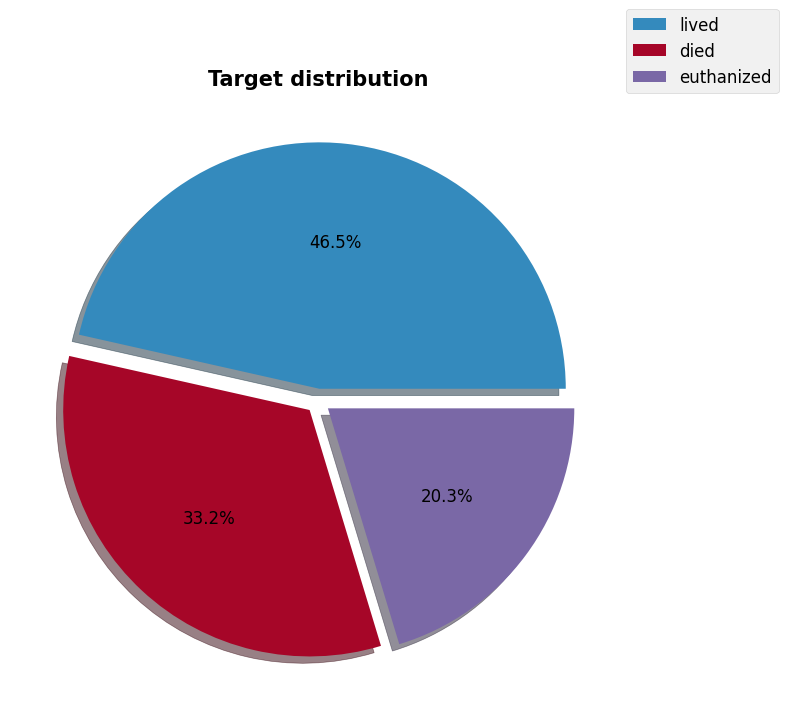

<Figure size 500x1000 with 0 Axes>

In [14]:
target_distribution = train['outcome'].value_counts()

plt.pie(target_distribution, shadow=True, explode=[.05,.05, .05], autopct='%.1f%%')

plt.title('Target distribution', size=15)
plt.legend(target_distribution.index, loc=[1.05, 1.1], bbox_to_anchor=(1, 1), fontsize=12)

plt.figure(figsize=(5,10));

**Distribution of the target variable by categorical types**

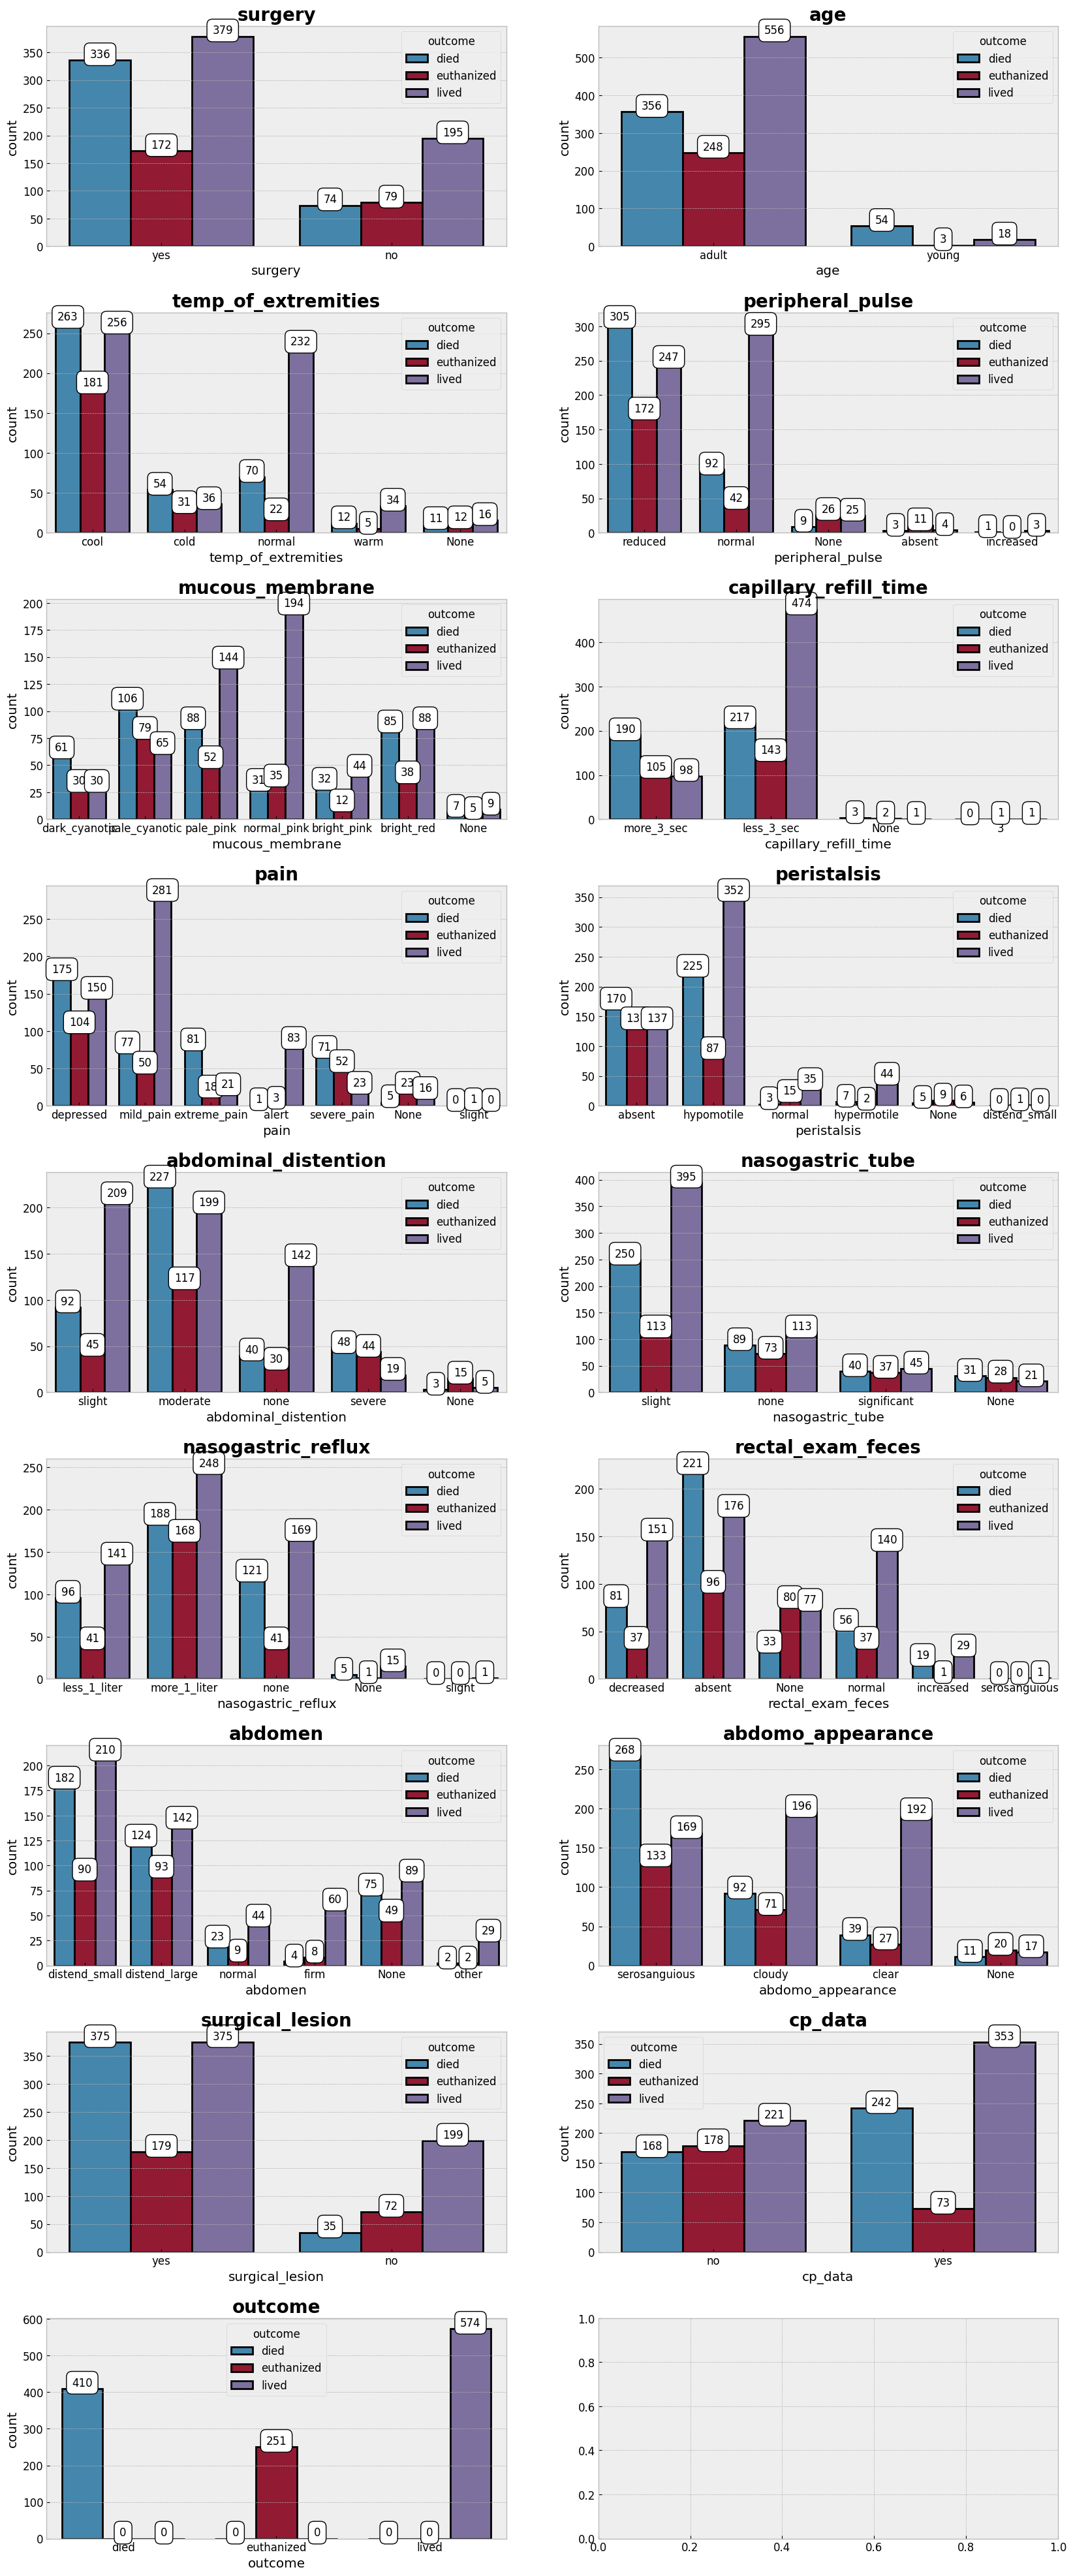

In [15]:
fig,axes = plt.subplots(9, 2, figsize = (20,50))
plt.subplots_adjust(hspace=0.3)

for i,c in enumerate(cat.columns):
    ax = axes[i//2, i%2]
    p1  = sns.countplot(data = train,
              x = c,
              hue = 'outcome',
              edgecolor = 'black',
              linewidth = 2,
              ax = ax)
    p1.bar_label(p1.containers[0], bbox = bbox)
    p1.bar_label(p1.containers[1], bbox = bbox)
    p1.bar_label(p1.containers[2], bbox = bbox)
    ax.set_title(c, fontweight= 'bold')
plt.show()

Surgery - if horses have surgery, the number of deaths among horses increases, and vice versa, if horses have not had surgery, more survive than die

Age - young horses are more likely to die

temp_of_extremities - at normal and warm emp_of_extremities, a large number of survive, while at cold emp_of_extremities about 50/50

peripheral_pulse - with a normal pulse, most of the surviving horses, while with a missing pulse, most horses are euthanized and with a reduced pulse, they die

mucous_membrane - with pale pink and normal pink mucous membranes, they have a better chance of survival than with dark cyanotic and pale cyanotic

etc..

**Distribution of the target variable by numeric columns**

In [16]:
float_list = num_float.columns.to_list()
int_list = num_int.columns.to_list()
num_list = int_list + float_list

print(f'Length of the list of numeric features = {len(num_list)}')
print('\n',num_list)

Length of the list of numeric features = 11

 ['hospital_number', 'lesion_1', 'lesion_2', 'lesion_3', 'rectal_temp', 'pulse', 'respiratory_rate', 'nasogastric_reflux_ph', 'packed_cell_volume', 'total_protein', 'abdomo_protein']


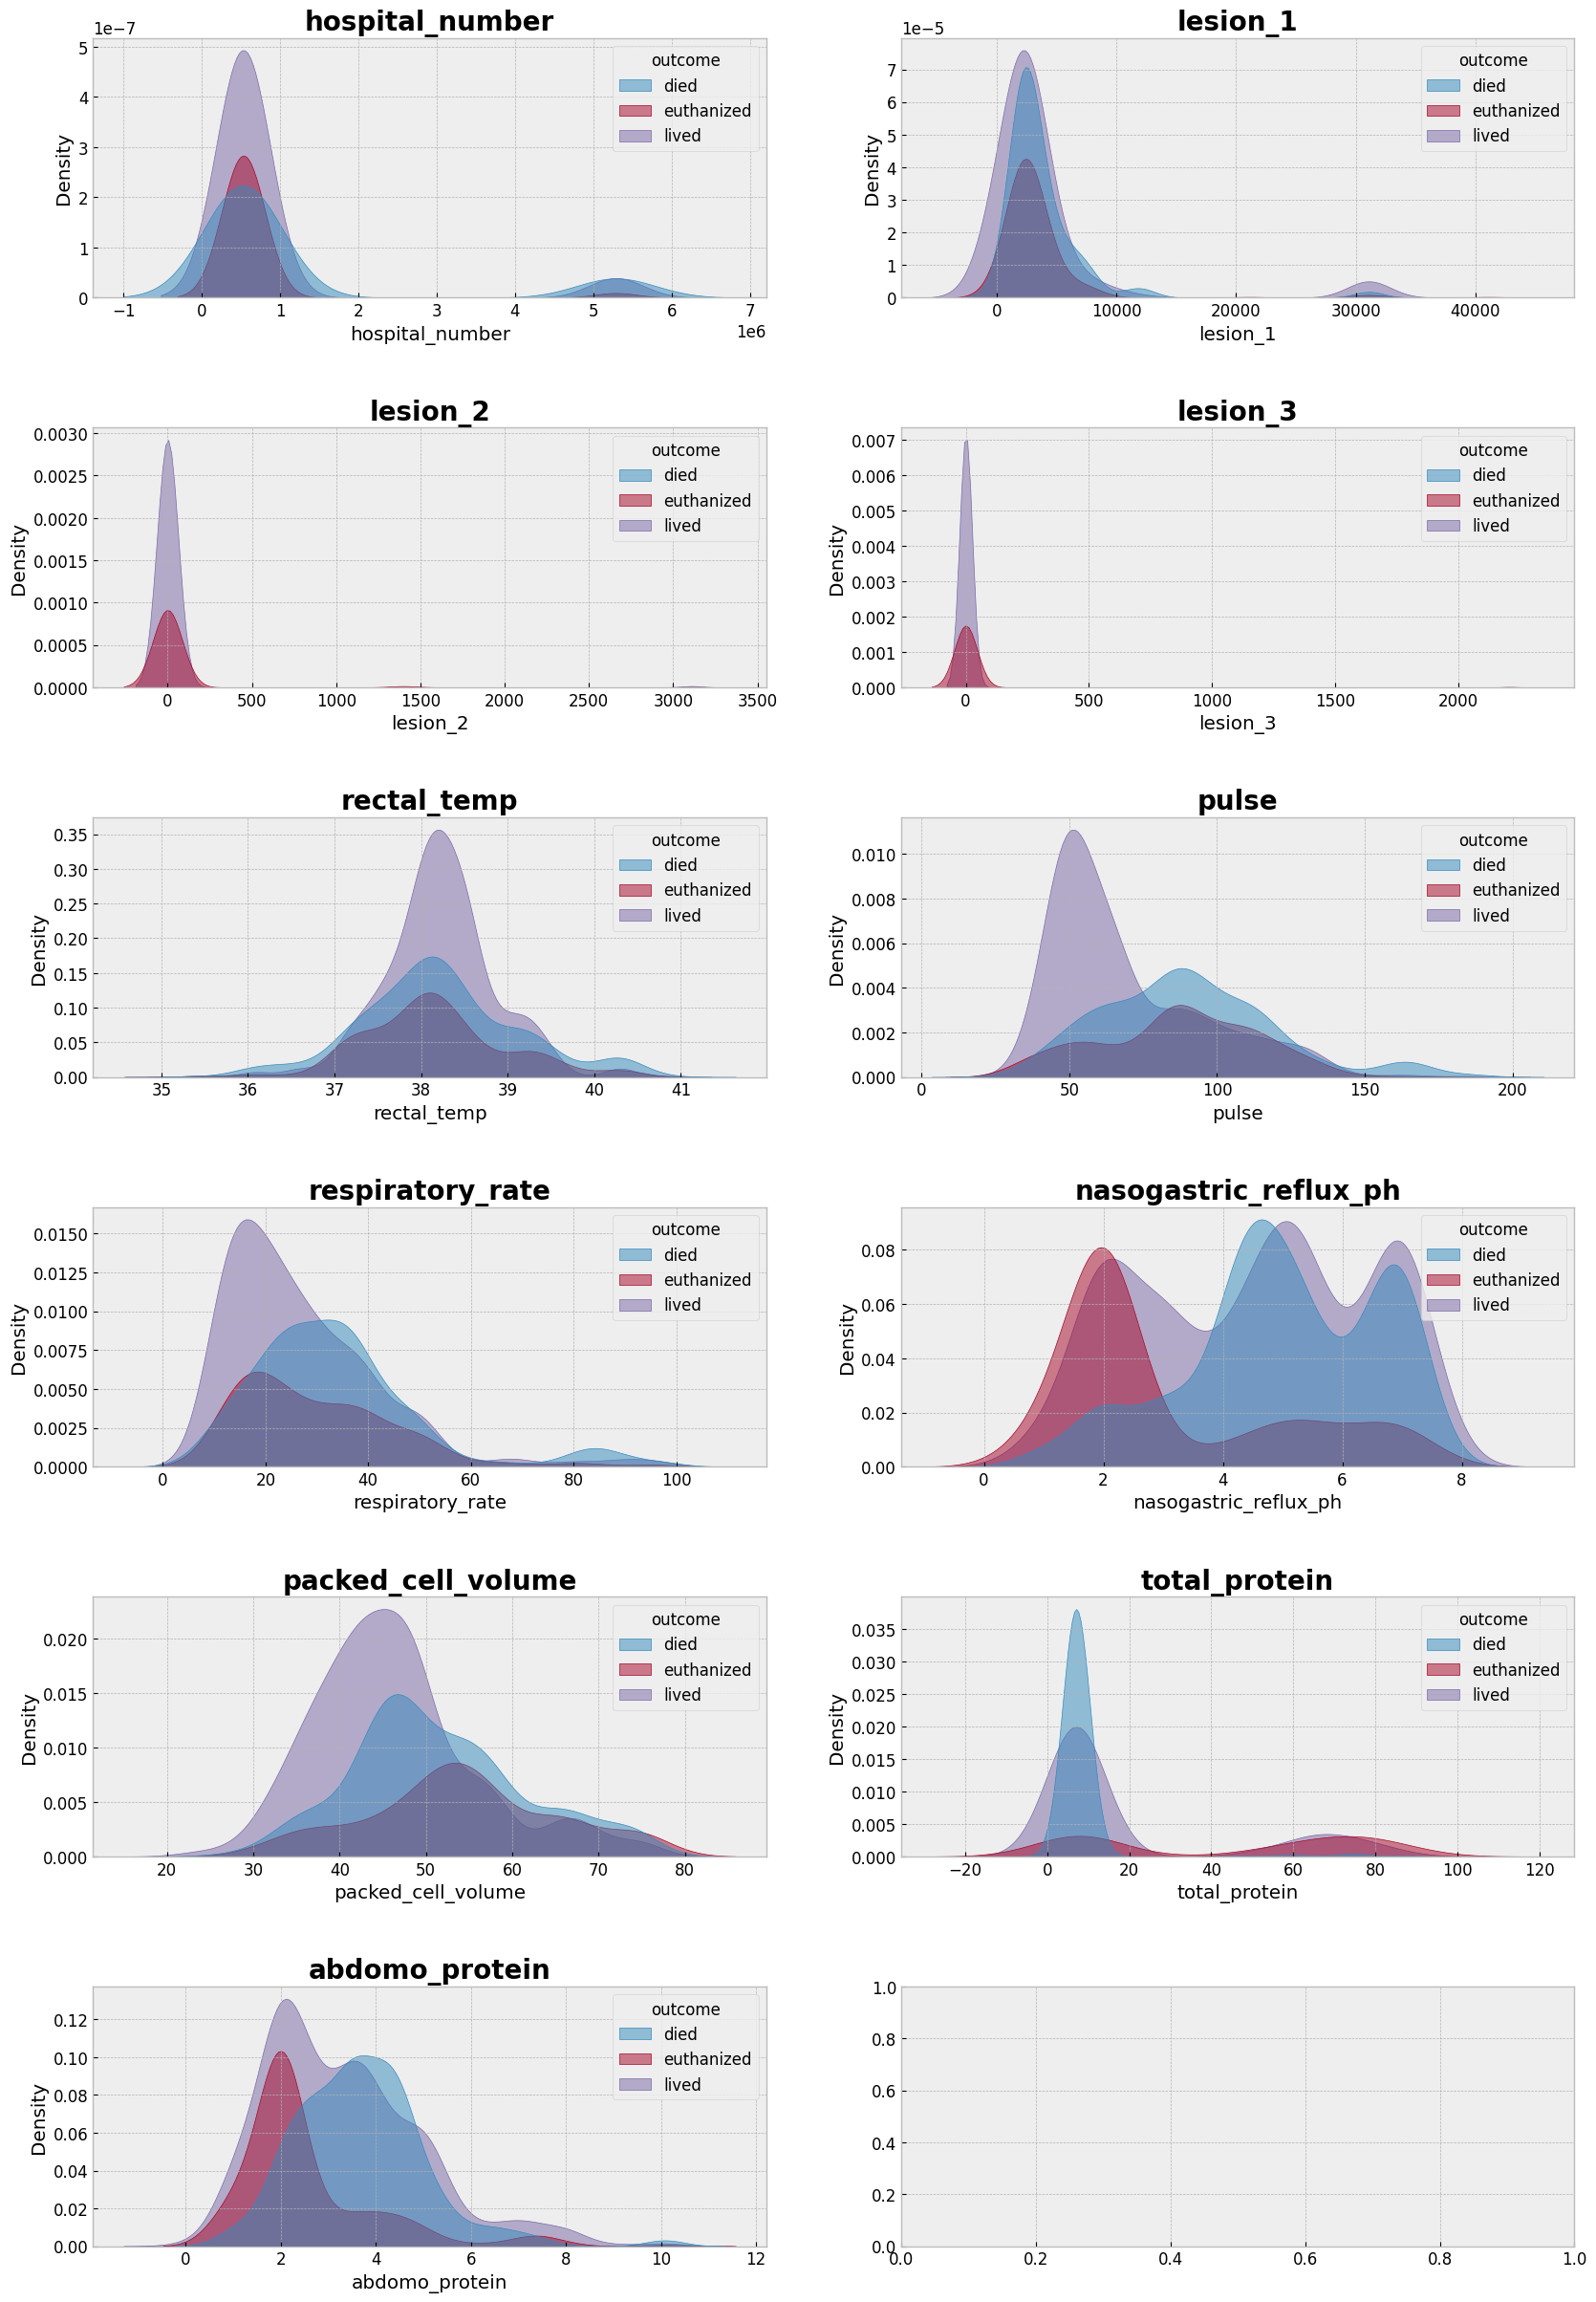

In [17]:
fig,axes = plt.subplots(6,2 ,figsize = (20,30))
plt.subplots_adjust(hspace=0.5)

for i,n in enumerate(num_list):
    ax = axes[i//2, i%2]
    sns.kdeplot(data = train,
                x = n,
                hue = 'outcome',
                ax = ax,
                alpha = 0.5,
                fill = True,
                warn_singular=False)

    ax.set_title(n, fontweight= 'bold')


plt.show()

lesion_2 and lesion_3 do not have the died class

at a temperature of 38 degrees, the probability density is the highest for class of lived

the survivors have a pulse mostly around 50

the respiration rate of survivors is lower than that of the deceased

total_protein  - the higher the index, the more likely euthanasia is

## 5. FEATURE ENGINEERING

From the description in the original dataset, the columns lesion_1, lesion_2 and lesion_3 encode the site, type, subtype, and specific code.

In [18]:
#train['lesion_1'].value_counts()
#train['lesion_2'].value_counts()
train['lesion_3'].value_counts()

0       1233
2209       2
Name: lesion_3, dtype: int64

To begin with, we will create new columns based on the encoded information in the columns lesion_1, lesion_2 and lesion_3

In [19]:
def map_lesion_site(value:str) -> str:
    if value[:2] == "11" and len(value) == 5:
        return "all_intestinal"
    elif value[0] == "1":
        return "gastric"
    elif value[0] == "2":
        return "sm_intestine"
    elif value[0] == "3":
        return "lg_colon"
    elif value[0] == "4":
        return "lg_colon_and_cecum"
    elif value[0] == "5":
        return "cecum"
    elif value[0] == "6":
        return "transverse_colon"
    elif value[0] == "7":
        return "retum_colon"
    elif value[0] == "8":
        return "uterus"
    elif value[0] == "9":
        return "bladder"
    elif value[0] == "0":
        return '0'
    else:
        return np.nan

In [20]:
train['lesion_site'] = train['lesion_1'].astype(str).apply(map_lesion_site)
test['lesion_site'] = test['lesion_1'].astype(str).apply(map_lesion_site)

train['lesion_site_2'] = train['lesion_2'].astype(str).apply(map_lesion_site)
test['lesion_site_2'] = test['lesion_2'].astype(str).apply(map_lesion_site)

train['lesion_site_3'] = train['lesion_3'].astype(str).apply(map_lesion_site)
test['lesion_site_3'] = test['lesion_3'].astype(str).apply(map_lesion_site)

<Axes: >

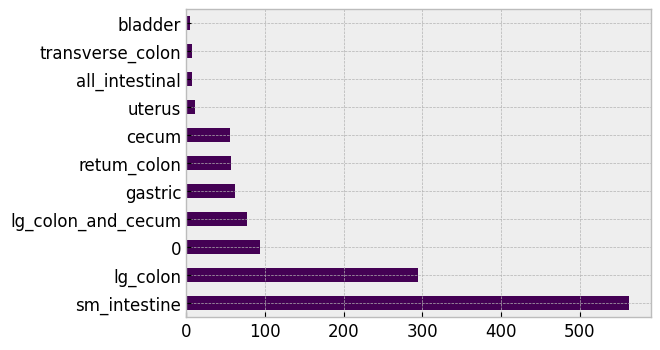

In [21]:
train['lesion_site'].value_counts().plot(kind='barh', figsize=(6,4), cmap='viridis')

<Axes: xlabel='count', ylabel='lesion_site'>

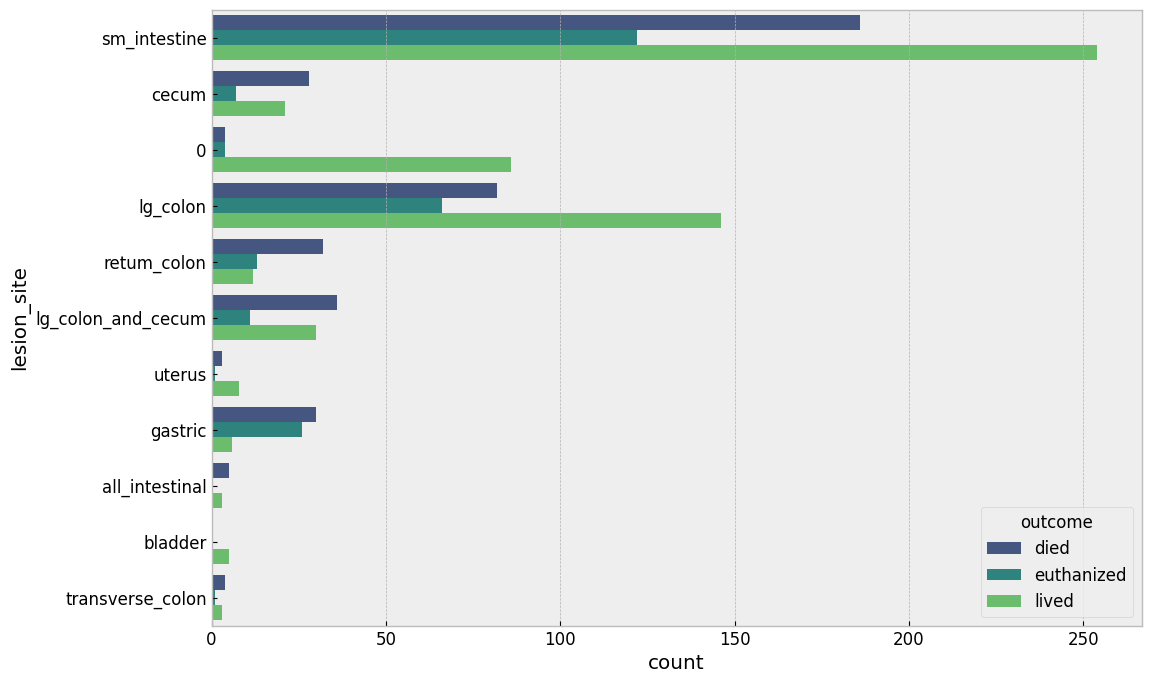

In [22]:
sns.countplot(train, y='lesion_site', hue='outcome', palette='viridis')

In [23]:
def map_lesion_type(value:str) -> str:
    if value == '0':
        return '0'

    if len(value) == 5:
        if value[:2] == '11':
            value2 = value[2]
            if value2 == '1':
                return "simple"
            elif value2 == '2':
                return 'strangulation'
            elif value2 == '3':
                return 'inflammation'
            elif value2 == '4':
                return 'other'
        else:
            value2 = value[1]
            if value2 == '1':
                return "simple"
            elif value2 == '2':
                return 'strangulation'
            elif value2 == '3':
                return 'inflammation'
            elif value2 == '4':
                return 'other'
    else:
        value2 = value[1]
        if value2 == '1':
            return "simple"
        elif value2 == '2':
            return 'strangulation'
        elif value2 == '3':
            return 'inflammation'
        elif value2 == '4':
            return 'other'
    return np.nan

In [24]:
train['lesion_type'] = train['lesion_1'].astype(str).apply(map_lesion_type)
test['lesion_type'] = test['lesion_1'].astype(str).apply(map_lesion_type)

train['lesion_type_2'] = train['lesion_2'].astype(str).apply(map_lesion_type)
test['lesion_type_2'] = test['lesion_2'].astype(str).apply(map_lesion_type)

train['lesion_type_3'] = train['lesion_3'].astype(str).apply(map_lesion_type)
test['lesion_type_3'] = test['lesion_3'].astype(str).apply(map_lesion_type)

<Axes: >

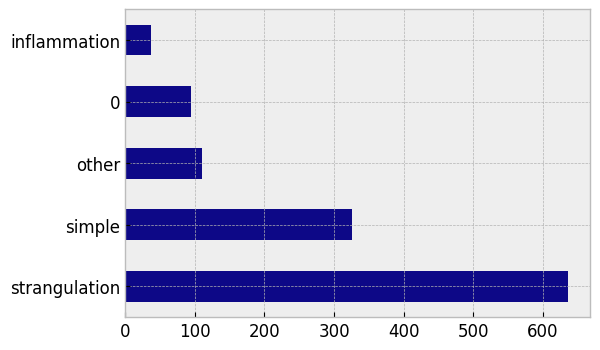

In [25]:
train['lesion_type'].value_counts().plot(kind='barh', figsize=(6,4), cmap='plasma')

<Axes: xlabel='count', ylabel='lesion_type'>

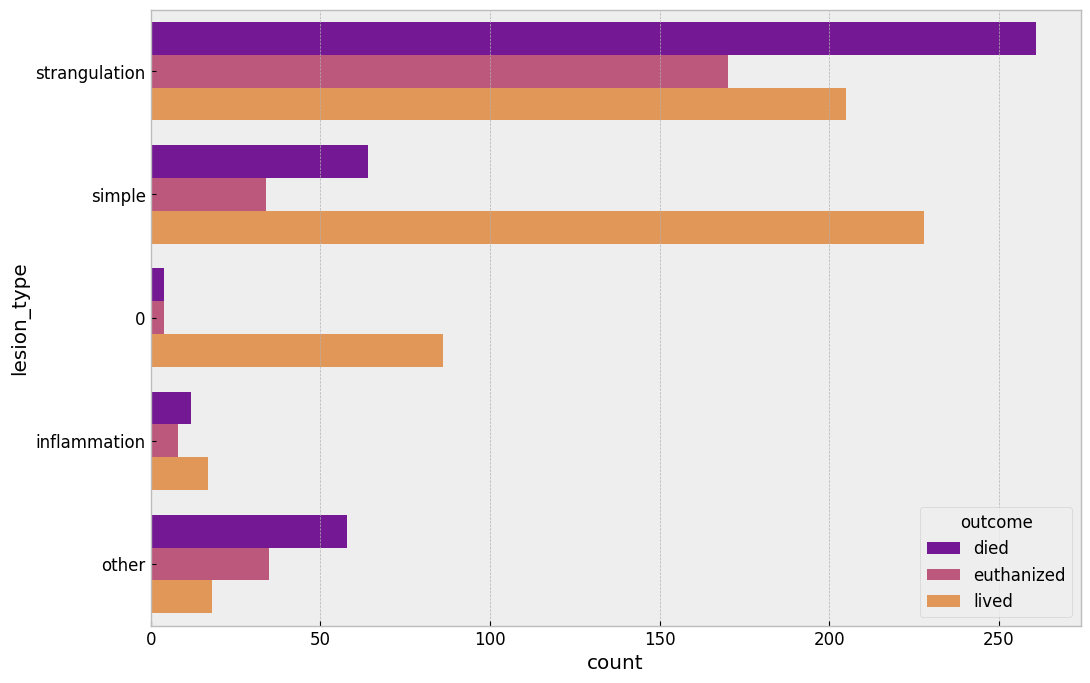

In [26]:
sns.countplot(train, y='lesion_type', hue='outcome', palette='plasma')

In [27]:
def map_lesion_subtype(value:str) -> str:
    if value == '0' or len(value) < 3:
        return '0'

    if len(value) == 5:
        if value[:2] == '11':
            value3 = value[3]
            if value3 == '1':
                return "mechanical"
            elif value3 == '2':
                return 'paralytic'
        else:
            value3 = value[2]
            if value3 == '1':
                return "mechanical"
            elif value3 == '2':
                return 'paralytic'
    else:
        value3 = value[2]
        if value3 == '1':
            return "mechanical"
        elif value3 == '2':
            return 'paralytic'
        else:
            return np.nan
    return np.nan

In [28]:
train['lesion_subtype'] = train['lesion_1'].astype(str).apply(map_lesion_subtype)
test['lesion_subtype'] = test['lesion_1'].astype(str).apply(map_lesion_subtype)

train['lesion_subtype_2'] = train['lesion_2'].astype(str).apply(map_lesion_subtype)
test['lesion_subtype_2'] = test['lesion_2'].astype(str).apply(map_lesion_subtype)

train['lesion_subtype_3'] = train['lesion_3'].astype(str).apply(map_lesion_subtype)
test['lesion_subtype_3'] = test['lesion_3'].astype(str).apply(map_lesion_subtype)

<Axes: >

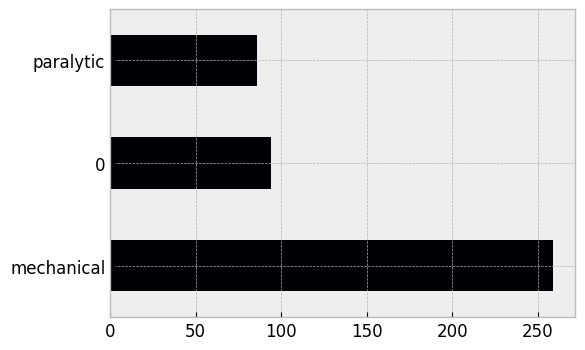

In [29]:
train['lesion_subtype'].value_counts().plot(kind='barh', figsize=(6,4), cmap='inferno')

<Axes: xlabel='count', ylabel='lesion_subtype'>

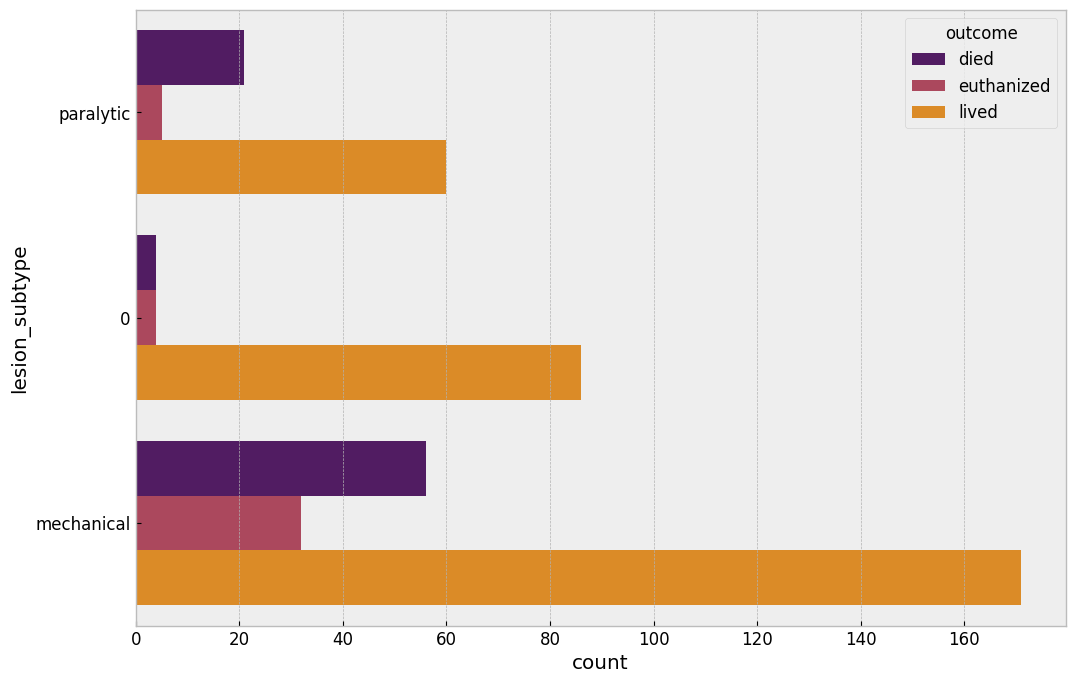

In [30]:
sns.countplot(train, y='lesion_subtype', hue='outcome', palette='inferno')

In [31]:
def map_lesion_specific_code(value:str) -> str:
    if value == '0' or len(value) < 4:
        return '0'

    if len(value) == 5:
        if value[:2] == '11':
            value4 = value[4]
            if value4 == '1':
                return "obturation"
            elif value4 == '2':
                return 'intrinsic'
            elif value4 == '3':
                return 'extrinsic'
            elif value4 == '4':
                return 'adynamic'
            elif value4 == '5':
                return 'volvulus/torsion'
            elif value4 == '6':
                return 'intussuption'
            elif value4 == '7':
                return 'thromboembolic'
            elif value4 == '8':
                return 'hernia'
            elif value4 == '9':
                return 'lipoma/slenic incarceration'
        else:
            value4 = value[3:]
            if value4 == '1':
                return "obturation"
            elif value4 == '2':
                return 'intrinsic'
            elif value4 == '3':
                return 'extrinsic'
            elif value4 == '4':
                return 'adynamic'
            elif value4 == '5':
                return 'volvulus/torsion'
            elif value4 == '6':
                return 'intussuption'
            elif value4 == '7':
                return 'thromboembolic'
            elif value4 == '8':
                return 'hernia'
            elif value4 == '9':
                return 'lipoma/slenic incarceration'
            elif value4 == '10':
                return 'displacement'
    else:
        value4 = value[3]
        if value4 == '1':
            return "obturation"
        elif value4 == '2':
            return 'intrinsic'
        elif value4 == '3':
            return 'extrinsic'
        elif value4 == '4':
            return 'adynamic'
        elif value4 == '5':
            return 'volvulus/torsion'
        elif value4 == '6':
            return 'intussuption'
        elif value4 == '7':
            return 'thromboembolic'
        elif value4 == '8':
            return 'hernia'
        elif value4 == '9':
            return 'lipoma/slenic incarceration'
        elif value4 == '10':
            return 'displacement'
    return np.nan

In [32]:
train['lesion_specific_code'] = train['lesion_1'].astype(str).apply(map_lesion_specific_code)
test['lesion_specific_code'] = test['lesion_1'].astype(str).apply(map_lesion_specific_code)

train['lesion_specific_code_2'] = train['lesion_2'].astype(str).apply(map_lesion_specific_code)
test['lesion_specific_code_2'] = test['lesion_2'].astype(str).apply(map_lesion_specific_code)

train['lesion_specific_code_3'] = train['lesion_3'].astype(str).apply(map_lesion_specific_code)
test['lesion_specific_code_3'] = test['lesion_3'].astype(str).apply(map_lesion_specific_code)

<Axes: >

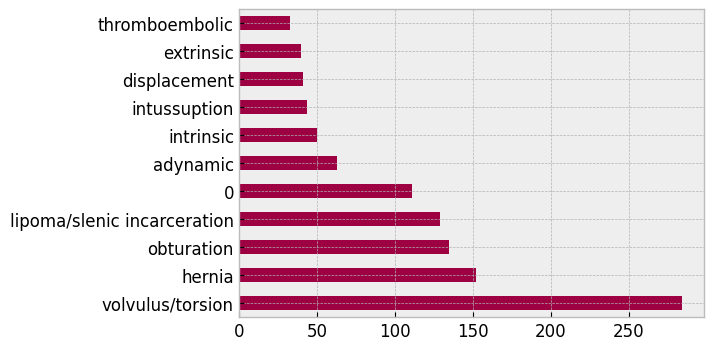

In [33]:
train['lesion_specific_code'].value_counts().plot(kind='barh', figsize=(6,4), cmap='Spectral')

<Axes: xlabel='count', ylabel='lesion_specific_code'>

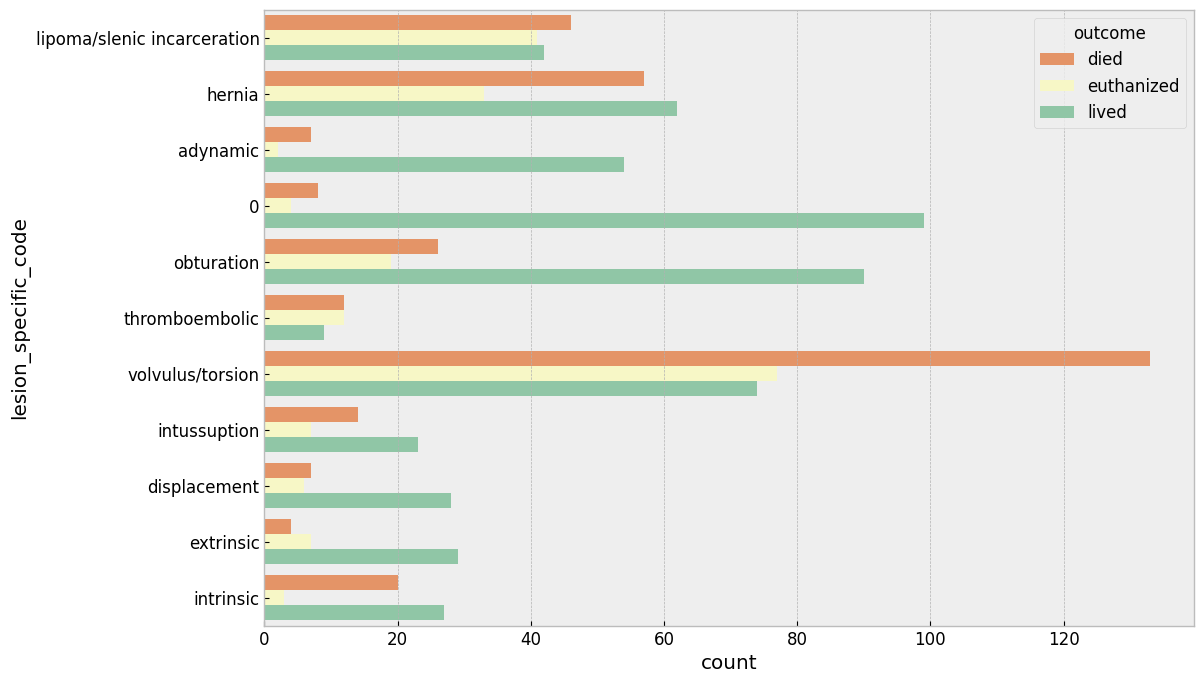

In [34]:
sns.countplot(train, y='lesion_specific_code', hue='outcome', palette='Spectral')

Delete the columns lesion_1, lesion_2, lesion_3

In [35]:
train.drop(['lesion_3', 'lesion_1', 'lesion_2'], axis=1, inplace=True)
test.drop(['lesion_3', 'lesion_1', 'lesion_2'], axis=1, inplace=True)

In [36]:
df_train = pd.DataFrame()
df_train['TYPES'] = train.dtypes
df_train['UNIQ_VALUE'] = train.nunique()
df_train['MISSING_VALUE'] = train.isna().sum()
df_train['MISSING_VALUE_%'] = round(df_train['MISSING_VALUE']  / train.shape[0], 4) * 100
df_train['COUNT'] = train.count() - df_train['MISSING_VALUE']
df_train

,TYPES,UNIQ_VALUE,MISSING_VALUE,MISSING_VALUE_%,COUNT
surgery,object,2,0,0.00,1235
age,object,2,0,0.00,1235
hospital_number,int64,255,0,0.00,1235
rectal_temp,float64,43,0,0.00,1235
pulse,float64,50,0,0.00,1235
respiratory_rate,float64,37,0,0.00,1235
temp_of_extremities,object,5,0,0.00,1235
peripheral_pulse,object,5,0,0.00,1235
mucous_membrane,object,7,0,0.00,1235
capillary_refill_time,object,4,0,0.00,1235


Delete column lesion_subtype (many missing values)

In [37]:
train.drop('lesion_subtype', axis=1, inplace=True)
test.drop('lesion_subtype', axis=1, inplace=True)

## 6. PREPROCESSING

In [38]:
X_train = train.drop(columns='outcome')
y_train = train[['outcome']]

In [39]:
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='mean'), # Tree based models like the LGBM deal with missing values better than SimpleImputer
    QuantileTransformer(output_distribution='normal', random_state=777),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OrdinalEncoder(handle_unknown='use_encoded_value' ,unknown_value=np.nan)
)

In [40]:
transformer = make_column_transformer(
    (
        numerical_pipeline,
        make_column_selector(dtype_include=np.number) # We want to apply numerical_pipeline only on numerical columns
    ),
    (
        categorical_pipeline,
        make_column_selector(dtype_include=object) # We want to apply categorical_pipeline only on object (string) columns
    ),
    remainder='passthrough', # If any column where missed then don't drop them - we take care of every column so this line is not necessery
    verbose_feature_names_out=False # if False transformer won't add prefixes (name of the transformer that generated specific feature) to column names, column names are shorter that way
)

transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('quantiletransformer',
                                                  QuantileTransformer(output_distribution='normal',
                                                                      random_state=777)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbef8012230>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fbee4920640>)],
                  verbose_feature_names_out=False)

In [41]:
target_encoder = OrdinalEncoder(categories=[['died', 'euthanized', 'lived']])

In [42]:
X_train = transformer.fit_transform(X_train)
y_train = target_encoder.fit_transform(y_train).ravel()

In [43]:
X_train = pd.DataFrame(data=X_train, columns=transformer.get_feature_names_out(), index=train.index)
X_train.head()

,hospital_number,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,surgery,age,...,lesion_site_2,lesion_site_3,lesion_type,lesion_type_2,lesion_type_3,lesion_subtype_2,lesion_subtype_3,lesion_specific_code,lesion_specific_code_2,lesion_specific_code_3
0,0.105878,-0.109224,1.700853,-0.187200,0.602077,0.558758,0.532677,0.118752,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0
1,0.492654,-0.950993,0.350477,-1.401771,-0.658106,-1.490259,0.920788,-0.774723,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
2,0.040881,0.252304,1.294186,0.031250,-0.196908,-1.022449,-0.940529,0.118752,1.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.318004,-1.563261,-0.081099,0.163864,-0.658106,0.292826,-0.400509,0.463496,1.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0
4,2.417133,-0.336523,-0.782074,1.073563,0.936927,-0.189014,-0.175523,-0.231932,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 7. MODELING

In [44]:
X_train_optuna, X_val_optuna, y_train_optuna, y_val_optuna = train_test_split(X_train, y_train, train_size=0.8, random_state=777)

In [ ]:
def objective(trial):
    # model = LGBMClassifier(
    #     n_estimators = trial.suggest_int('n_estimators', 32, 1024),
    #     learning_rate = trial.suggest_float('learning_rate', 0.001, 0.5),
    #     max_depth = trial.suggest_int('max_depth', 1, 10),
    #     num_leaves = trial.suggest_int('num_leaves', 2, 1024),
    #     reg_lambda  = trial.suggest_float('reg_lambda', 0.001, 10),
    #     reg_alpha = trial.suggest_float('reg_alpha', 0, 10),
    #     subsample = trial.suggest_float('subsample', 0.001, 1),
    #     colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1),
    #     min_child_samples = trial.suggest_int('min_child_samples', 2, 1024),
    #     min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
    #     objective = trial.suggest_categorical('objective', ['multiclass']),
    #     metric = trial.suggest_categorical('metric', ['multi_logloss']),
    #     random_state = trial.suggest_categorical('random_state', [777]),
    #     boosting_type = trial.suggest_categorical('boosting_type', ["gbdt", "dart", "goss"]),
    # )

#     model = CatBoostClassifier(
#         iterations = trial.suggest_int('iterations', 32, 1024),
#         learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3),
#         depth = trial.suggest_int('depth', 1, 10),
#         l2_leaf_reg = trial.suggest_float('l2_leaf_reg', 0.01, 10),
#         grow_policy = trial.suggest_categorical('grow_policy', ['Depthwise']),
#         bootstrap_type = trial.suggest_categorical('bootstrap_type', ['Bayesian']),
#         od_type = trial.suggest_categorical('od_type', ['Iter']),
#         eval_metric = trial.suggest_categorical('eval_metric', ['TotalF1']),
#         loss_function = trial.suggest_categorical('loss_function', ['MultiClass']),
#         random_state = trial.suggest_categorical('random_state', [777]),
#         verbose = trial.suggest_categorical('verbose', [0])
#     )

    model = XGBClassifier(
        eta = trial.suggest_float('eta', 0.001, 0.3),
        n_estimators = trial.suggest_int('n_estimators', 32, 1024),
        max_depth = trial.suggest_int('max_depth', 1, 10),
        reg_lambda = trial.suggest_float('reg_lambda', 0.01, 10),
        subsample = trial.suggest_float('subsample', 0.01, 1),
        min_child_weight = trial.suggest_int('min_child_weight', 1, 10),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1),
        random_state = trial.suggest_categorical('random_state', [777]),
        objective = trial.suggest_categorical('objective', ['multi:softmax'])
    )

    model.fit(
        X_train_optuna, y_train_optuna,
        eval_set=[(X_train_optuna, y_train_optuna), (X_val_optuna, y_val_optuna)],
        #verbose=False
    )

    return f1_score(y_val_optuna, model.predict(X_val_optuna), average='micro') # micro F1 is used in this competitons for evaluation so we will use it for hyperparameter optimization

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_hyperparams = study.best_params
best_hyperparams

In [ ]:
best_hyperparams_xgb = {'eta': 0.029313129630049763,
 'n_estimators': 428,
 'max_depth': 5,
 'reg_lambda': 0.9343926112434864,
 'subsample': 0.9232220647866121,
 'min_child_weight': 4,
 'colsample_bytree': 0.10649391933887928,
 'random_state': 777,
 'objective': 'multi:softmax'}

best_hyperparams_lgbm = {'n_estimators': 814,
 'learning_rate': 0.11029472933812774,
 'max_depth': 8,
 'num_leaves': 253,
 'reg_lambda': 0.8188140489848093,
 'reg_alpha': 0.8897994271041242,
 'subsample': 0.7869132186546186,
 'colsample_bytree': 0.6199255016830987,
 'min_child_samples': 102,
 'min_child_weight': 4,
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'random_state': 777,
 'boosting_type': 'dart'}

best_hyperparams_cb = {'iterations': 803,
 'learning_rate': 0.12264157522210103,
 'depth': 3,
 'l2_leaf_reg': 9.53946190566285,
 'grow_policy': 'Depthwise',
 'bootstrap_type': 'Bayesian',
 'od_type': 'Iter',
 'eval_metric': 'TotalF1',
 'loss_function': 'MultiClass',
 'random_state': 777,
 'verbose': 0}

In [ ]:
models = [
    XGBClassifier(**best_hyperparams_xgb),
    LGBMClassifier(**best_hyperparams_lgbm),
    CatBoostClassifier(**best_hyperparams_cb)
]

In [ ]:
for model in models:
    cv_score = cross_val_score(model, X_train, y_train, cv=5, scoring='f1_micro').sum() / 5

    print(f'{model.__class__.__name__} micro F1 cross-validation score: {cv_score:.3f}')

XGBClassifier micro F1 cross-validation score: 0.726
LGBMClassifier micro F1 cross-validation score: 0.711
CatBoostClassifier micro F1 cross-validation score: 0.717


In [ ]:
for model in models:
    model.fit(X_train, y_train)

In [ ]:
for model in models:
    train_score = f1_score(y_train, model.predict(X_train), average='micro')

    print(f'{model.__class__.__name__} micro F1 training score: {train_score:.3f}')

XGBClassifier micro F1 training score: 0.869
LGBMClassifier micro F1 training score: 0.929
CatBoostClassifier micro F1 training score: 0.906


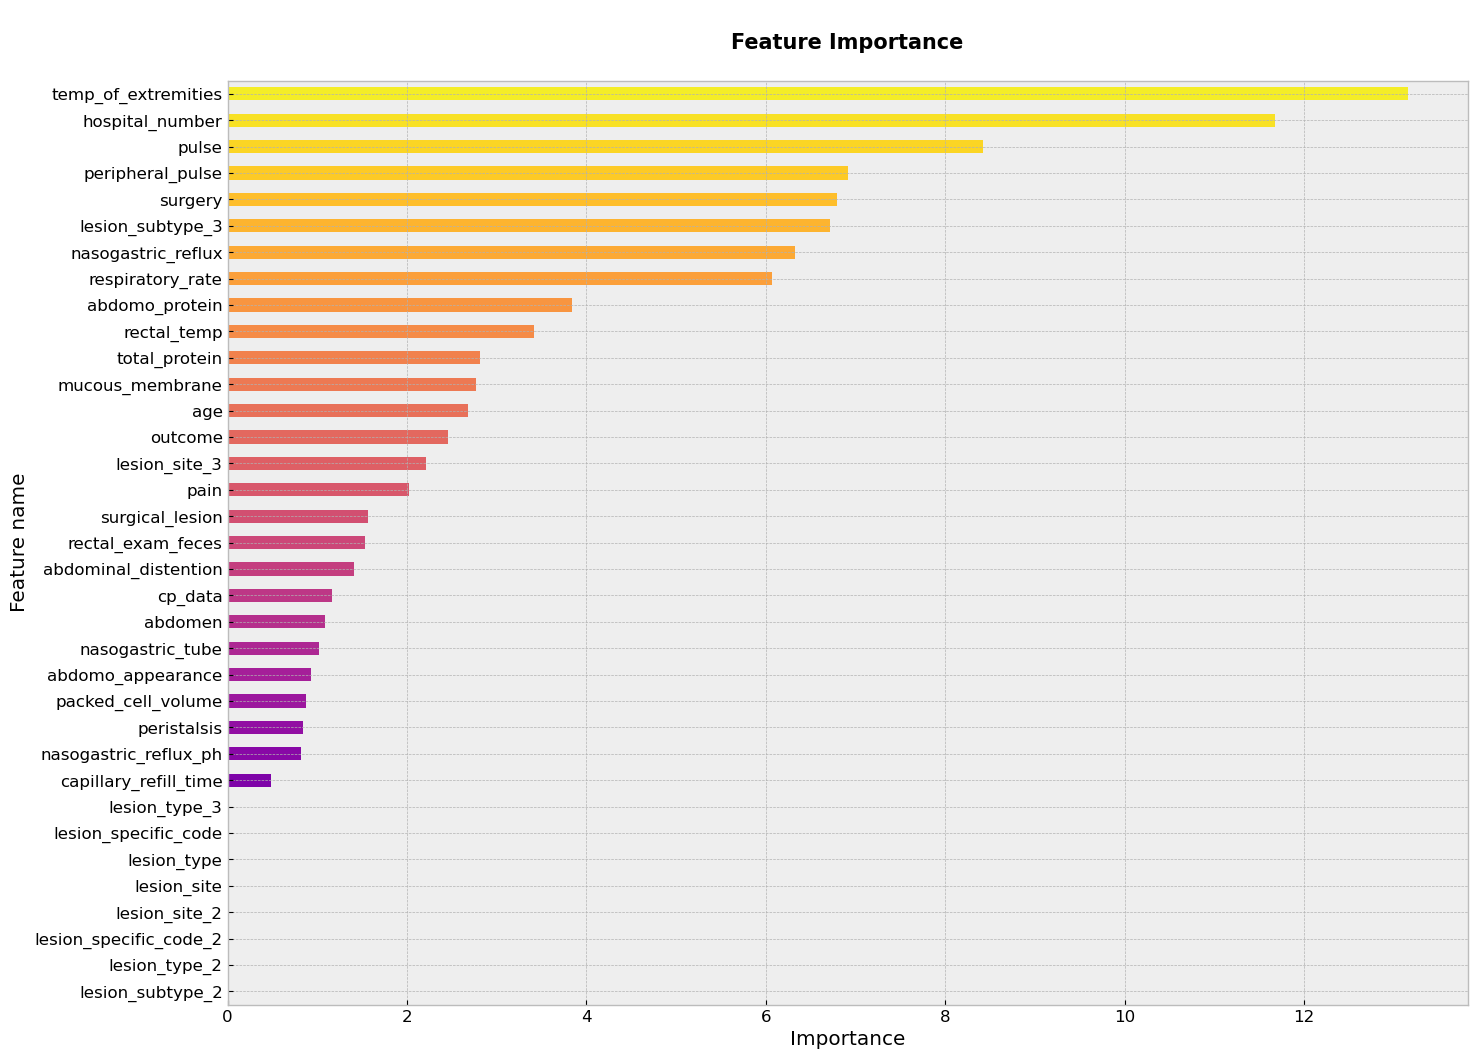

In [ ]:
feature_importance = pd.DataFrame(data = {'feature': train.columns[:-1], 'importance': model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=True)

feature_importance.plot(kind='barh', x='feature', y='importance', legend=False, color=sns.color_palette('plasma', n_colors=len(feature_importance)), figsize=(16, 12))

plt.xlabel('Importance')
plt.ylabel('Feature name')
plt.title('\nFeature Importance\n', fontsize=15)
plt.show()

In [ ]:
X_test = pd.DataFrame(data=transformer.transform(test), columns=transformer.get_feature_names_out(), index=test.index)

In [ ]:
predictions = []
for model in models:
    predictions.append(model.predict(X_test).ravel()) # CatBoostClassifier's predictions are of shape (n ,1) and not (n, ) like other models so we have to use .ravel()

# Mode doesn't work on python lists only on ndarray (numpy arrays)
predictions = np.array(predictions)

# Take the most frequent prediction out of 3 models
final_predictions, _ = stats.mode(predictions, axis=0)

final_predictions.shape

(1, 824)

## 8. SUBMISSION

In [ ]:
submission = pd.read_csv('../input/playground-series-s3e22/sample_submission.csv')
submission['outcome'] = target_encoder.inverse_transform(final_predictions.reshape(-1, 1)).ravel()

print(submission)
submission.to_csv('submission.csv', index = False)

       id     outcome
0    1235       lived
1    1236        died
2    1237       lived
3    1238  euthanized
4    1239       lived
..    ...         ...
819  2054        died
820  2055  euthanized
821  2056        died
822  2057       lived
823  2058       lived

[824 rows x 2 columns]
